In [26]:
import numpy as np

## 0.初步设计

* 网络为4层的全连接网络，完成二分类任务
* 输入节点为2，隐藏层节点数分别为25、50、25，输出层节点为2
* 采用sigmoid激活函数、均方差误差函数，不采用softmax对网络输出概率进行约束（以便利用a07.07中的反向传播推导公式）

![](https://github.com/zfhxi/Learn_tensorflow/blob/master/ch07-%E5%8F%8D%E5%90%91%E4%BC%A0%E6%92%AD%E7%AE%97%E6%B3%95/img/19.png?raw=true)

## 1.数据集
采用scikit-learn库提供的工具生成2000个线性不可分的2分类数据库。<br>
按照1400:600切分训练集和测试集。

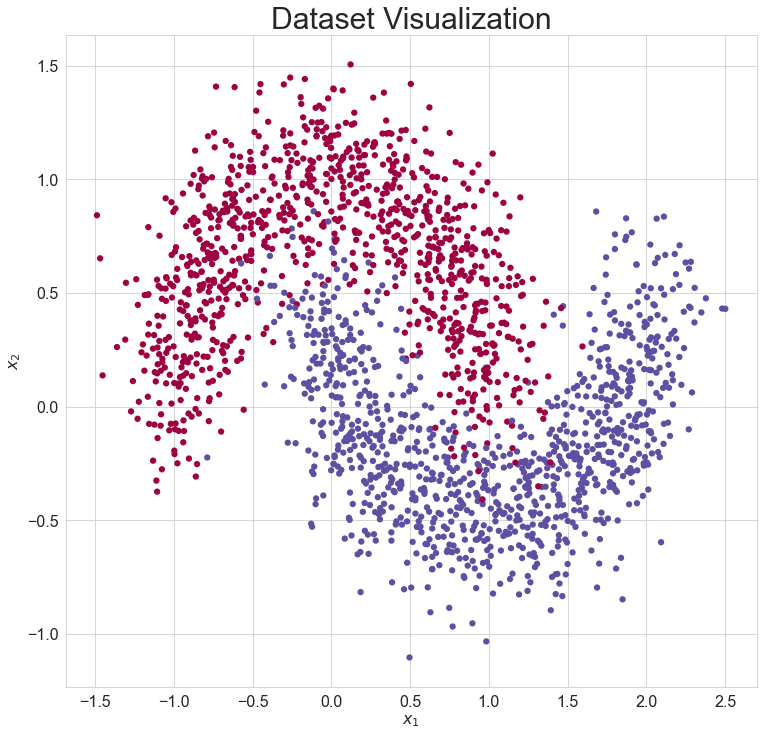

In [27]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

def load_dataset():
    N_SAMPLES=2000 # 采样点数
    TEST_SIZE=0.3 # 测试数量比率
    # 利用工具函数直接生成数据集
    X,y=make_moons(n_samples=N_SAMPLES,noise=0.2,random_state=100)
    # 数据切分
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=TEST_SIZE,random_state=42)
    return X,y,X_train,X_test,y_train,y_test

# 可视化数据集分布
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.size']=16
def make_plot(X,y,plot_name=None,XX=None,YY=None,preds=None,dark=False):
    if(dark):
        plt.style.use('dark_background')
    else:
        sns.set_style('whitegrid')
    plt.figure(figsize=(16,12))
    axes=plt.gca()
    axes.set(xlabel='$x_1$',ylabel='$x_2$')
    plt.title(plot_name,fontsize=30)
    plt.subplots_adjust(left=0.2)
    plt.subplots_adjust(right=0.8)
    if XX is not None and YY is not None and preds is not None:
        plt.contourf(XX,YY,preds.reshape(XX.shape),25,alpha=1,cmap=plt.cm.Spectral)
        plt.contour(XX,YY,preds.reshape(XX.shape),levels=[.5],cmap='Greys',vmin=0,vmax=.6)
    # 绘制散点图，根据标签区分颜色
    plt.scatter(X[:,0],X[:,1],c=y.ravel(),s=40,cmap=plt.cm.Spectral,edgecolors='none')
    plt.show()

X,y,X_train,X_test,y_train,y_test=load_dataset()
make_plot(X,y,'Dataset Visualization')

## 2.网络层类的定义

实现一个网络层，传入输入节点数、输出节点数、激活函数类型等参数，权值和偏置张量在初始化时根据输入、输出节点数自动生成并初始化。代码如下：

In [28]:
class Layer:
    # 全连接层
    def __init__(self,n_input,n_neurons,activation=None,weights=None,bias=None):
        """
        :param n_input: 输入节点数
        :param n_neurons: 输出节点数
        :param activation: 激活函数类型
        :param weights: 权值张量，默认内部生成，可接受传入参数
        :param bias: 偏置张量，默认内部生成
        """
        # 通过正态分布初始化网络权值
        self.weights=weights if weights is not None else np.random.randn(n_input,n_neurons)*np.sqrt(1/n_neurons)
        self.bias=bias if bias is not None else np.random.rand(n_neurons)*0.1

        self.activation=activation # 激活函数类型
        self.last_activation=None # 激活函数的输出值

        self.delta=None # 记录当前层的delta变量，用于计算梯度
        self.error=None # 用于计算当前层的delta变量的中间变量

    def _apply_activation(self,r):
        """
        计算激活函数的输出
        """
        if self.activation is None: # 无激活函数，直接返回
            return r
        elif self.activation=='relu': # ReLU
            return np.maximum(r,0)
        elif self.activation=='tanh': # tanh
            return np.tanh(r)
        elif self.activation=='sigmoid': # sigmoid
            return 1/(1+np.exp(-r))
        else: # 如果是其他类型，也直接返回
            return r

    def activate(self,x):
        """
        前向传播函数
        """
        r=np.dot(x,self.weights)+self.bias # X@W+b，np.dot向量内积或者矩阵积
        self.last_activation=self._apply_activation(r)
        return self.last_activation

    def apply_activation_derivative(self,r):
        """
        计算激活函数的导数
        """
        if self.activation is None: # 无激活函数，导数为1
            return np.ones_like(r)
        elif self.activation=='relu':
            grad=np.array(r,copy=True)
            grad[r>0]=1.
            grad[r<=0]=0.
            return grad
        elif self.activation=='tanh':
            return 1-r**2
        elif self.activation=='sigmoid':
            return r*(1-r)
        else:
            return r

## 3.网络模型

创建单层网络类后，我们实现网络模型的NeuralNetwork类，它内部维护各层的网络层Layer类对象，可以通过add_layer函数追加网络层，实现创建不同结构的网络模型目的。

In [29]:
class NeuralNetwork:
    """
    神经网络模型大类
    """
    def __init__(self):
        self._layers=[] # 网络层对象列表
    def add_layer(self,layer):
        """ 追加网络层
        """
        self._layers.append(layer)
    def feed_forward(self,X):
        """ 前向传播
        循环调用网络层对象列表中对象的前向计算函数
        """
        for layer in self._layers:
            X=layer.activate(X)
        return X
    def backpropagation(self,X,y,learning_rate):
        """ 反向传播
        """
        output=self.feed_forward(X) # 前向计算得到输出值
        # 计算-delta
        for i in reversed(range(len(self._layers))): # 反向循环
            layer=self._layers[i]
            if layer==self._layers[-1]: # 当前层对象是输出层
                # 此处是计算delta_k，参考a07.07反向传播偏导数计算规律
                layer.error=y-output
                layer.delta=layer.error*layer.apply_activation_derivative(output)
            else: # 当前层是隐藏层
                next_layer=self._layers[i+1] # 得到下一层对象
                layer.error=np.dot(next_layer.weights,next_layer.delta)
                layer.delta=layer.error*layer.apply_activation_derivative(layer.last_activation)

        # 循环更新权值
        for i in range(len(self._layers)):
            layer=self._layers[i]
            # 将输入转化为至少两维
            o_i=np.atleast_2d(X if i==0 else self._layers[i-1].last_activation)
            # 梯度下降算法
            layer.weights+=layer.delta*o_i.T*learning_rate # 此处用'+'是因为计算了-delta

    def predict(self,X):
        return self.feed_forward(X)
    def accuarcy(self,X,y):
        return np.sum(np.equal(np.argmax(X,axis=1),y))/y.shape[0]

    def train(self,X_train,X_test,y_train,y_test,learning_rate,max_epochs):
        ''' 训练网络
        '''
        # one-hot编码
        y_onehot=np.zeros((y_train.shape[0],2))
        y_onehot[np.arange(y_train.shape[0]),y_train]=1

        # 计算均方差误差
        mses=[]
        accuracys=[]
        for i in range(max_epochs): # 循环训练
            for j in range(len(X_train)): #  一次训练一个样本
                self.backpropagation(X_train[j],y_onehot[j],learning_rate)
            if i%10==0:
                # 打印MSE Loss
                mse=np.mean(np.square(y_onehot-self.feed_forward(X_train)))
                mses.append(mse)
                accuracy=self.accuarcy(self.predict(X_test),y_test.flatten())
                accuracys.append(accuracy)
                print(f'Epoch[{i}] MSE: {float(mse)} ',end='')
                # 统计并打印准确率
                print(f'Accuracy: {accuracy*100}%')
        return mses,accuracys

## 4.实例化网络对象并训练评估

根据前图的网络设计来实现：

In [30]:
nn=NeuralNetwork()
nn.add_layer(Layer(2,25,'sigmoid')) # 隐藏层1，2=>25
nn.add_layer(Layer(25,50,'sigmoid')) # 隐藏层2，25=>50
nn.add_layer(Layer(50,25,'sigmoid')) # 隐藏层3，50=>25
nn.add_layer(Layer(25,2,'sigmoid')) # 输出层，25=>2

mses,accuracys=nn.train(X_train,X_test,y_train,y_test,0.01,1000)

Epoch[0] MSE: 0.25046149887707225 Accuracy: 49.5%
Epoch[10] MSE: 0.17607844295845296 Accuracy: 80.83333333333333%
Epoch[20] MSE: 0.10141176564661099 Accuracy: 87.16666666666667%
Epoch[30] MSE: 0.09672740984240356 Accuracy: 88.33333333333333%
Epoch[40] MSE: 0.09642559987302754 Accuracy: 89.16666666666667%
Epoch[50] MSE: 0.0963687788107345 Accuracy: 89.16666666666667%
Epoch[60] MSE: 0.09633488220457904 Accuracy: 89.16666666666667%
Epoch[70] MSE: 0.09630513994347516 Accuracy: 89.16666666666667%
Epoch[80] MSE: 0.0962767858976063 Accuracy: 89.16666666666667%
Epoch[90] MSE: 0.09624935794339597 Accuracy: 89.0%
Epoch[100] MSE: 0.09622308425023002 Accuracy: 89.0%
Epoch[110] MSE: 0.0961983691944222 Accuracy: 89.0%
Epoch[120] MSE: 0.0961755265811591 Accuracy: 88.83333333333333%
Epoch[130] MSE: 0.09615467545645606 Accuracy: 88.83333333333333%
Epoch[140] MSE: 0.09613574432991585 Accuracy: 88.83333333333333%
Epoch[150] MSE: 0.09611852594404041 Accuracy: 88.83333333333333%
Epoch[160] MSE: 0.096102740

## 5.可视化结果

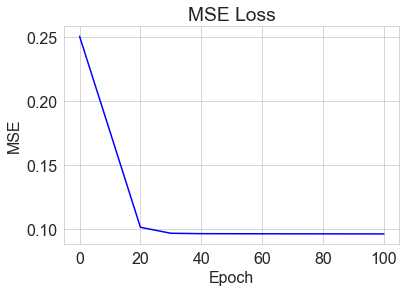

In [31]:
x=[i for i in range(0,101,10)]

# 绘制MSE曲线
plt.title('MSE Loss')
plt.plot(x,mses[:11],color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

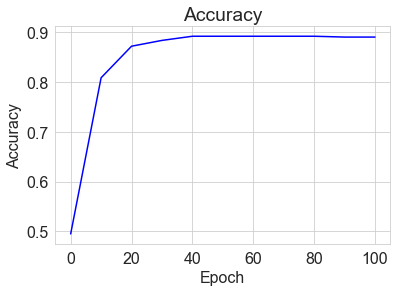

In [32]:
# 绘制Accuracy曲线
plt.title('Accuracy')
plt.plot(x,accuracys[:11],color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
import os
pid=os.getpid()
!kill -9 $pid